# Eval year combination

**Motivation:** I was wondering if I was suffering from limited training stats for the flow training setup, so I did this study where I combined the 2016, 2017, and 2018 datasets *together* for a combined pretraining.

<img src="figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/trainAll/m_hh_cor2_SR.pdf" width=400>

I also compared against the *combined* training for each of the years individually, but one of the follow-ups from Sean (and then later Michael) was to look at a comparison of the combined training *on* the combined years prediction.


In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

import os
os.sys.path += ['../GraphNN/','../Flow-Models/','../gp-for-flows/','../PyATLASstyle/'] 
from preprocess import MDpT_cut,MDR_cut

from densityEstimate import *
from densityPlots import *

# from bkgPred import *

from plotting import SR_x, SR_y1, SR_y2

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Load in the histograms**

In [20]:
L, H, nb, K, lr, beta, p = 10,32,1,4,1e-3,1e-6,.1

cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
colTag = '_'.join(cols)

s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'

tag = '_SM_2b_p_0.01'
prodTag = 'FEB20'
ntag = 2

In [6]:
hists = {}

for yr in [16,17,18]:
    
    subDir = f'data{yr}_PFlow-FEB20-5jets'
    mDir = f'../Flow-Models/models/{subDir}_SM_2b_p_0.01_2b_detaCut/'
    mDir += f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

    hists[yr] = []
    for md,ti in zip([mDir,mDir.replace(f'{yr}','161718'),mDir+'_data161718'],
                     ['',f'_{yr}','_data161718']):

        histFile = os.path.join(md,f'hists1d{ti}.json')
        print(histFile)
        with open(histFile, 'r') as varfile:
            out = json.load(varfile)

        # Go from lists -> np.arrays and append to the hists
        for k in out.keys():
            out[k] = np.array(out[k])

        hists[yr].append(out)
 

../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d.json
../Flow-Models/models/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d_16.json
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0_data161718/hists1d_data161718.json
../Flow-Models/models/data17_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d.json
../Flow-Models/models/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_

In [10]:
# text = "$\mathbf{ATLAS}$ data Internal\n"
# text += f"20{yr} data FEB2020 MNT prod\n"
# text += "DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM},|\Delta \eta_{hh}|$ < 1.5"

In [9]:
myVars = ['m_hh','m_hh_cor2','abs_deta_hh','absCosThetaStar',
          'pT_h1', 'pT_h2', 'eta_h1', 'eta_h2', 'dphi_hh']

bins = 50
myRanges = [(200,1200),(250,1250),(0,1.75),(0,1),
            (0,400),(0,400),(-3,3),(-3,3),(-.5,np.pi)]

varLabels = ['$m_{hh}$ [GeV]','$m_{hh}^{cor,2}$ [GeV]',
             '$|\Delta \eta_{hh}|$','$|\cos \Theta *|$',
             '$p_T^{h1}$','$p_T^{h2}$','$\eta_{h1}$','$\eta_{h2}$','$\Delta \Phi_{hh}$']

In [15]:
title='SR: 1% 2b stats'

In [38]:
yrs = [16,17,18]

h_2b = {yr:{} for yr in yrs}

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set
../data/data17_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 43161 events from 43161 available for the training / validation set
../data/data18_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 94075 events from 94075 available for the training / validation set


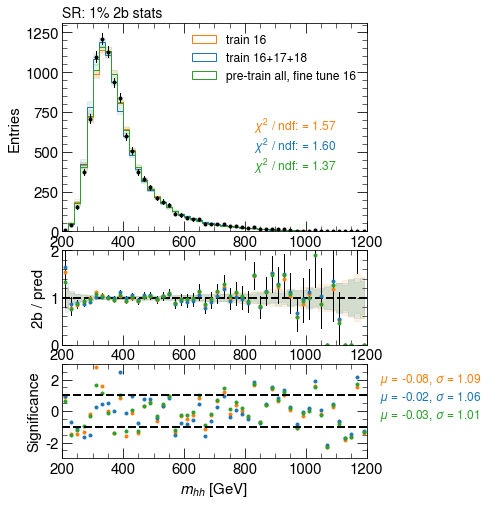

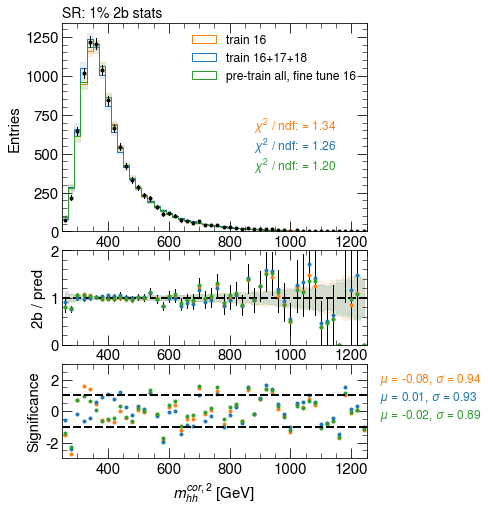

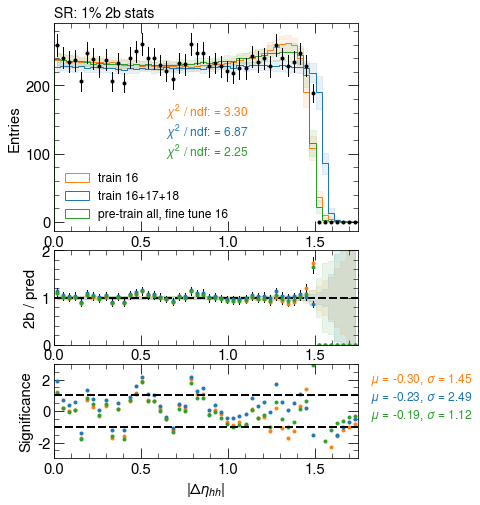

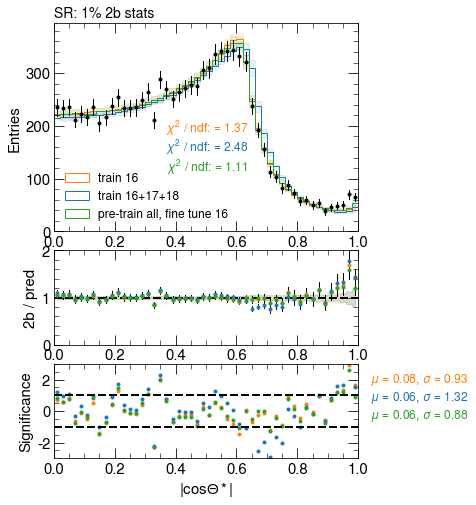

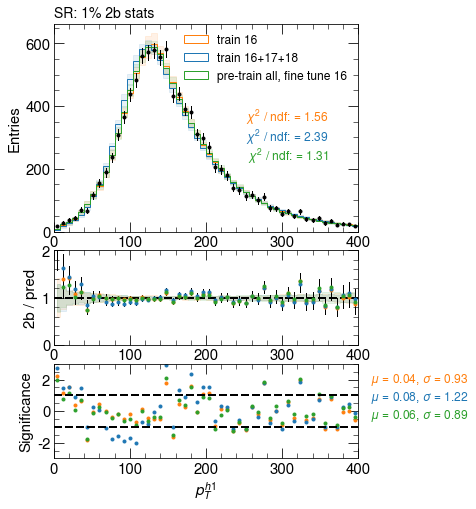

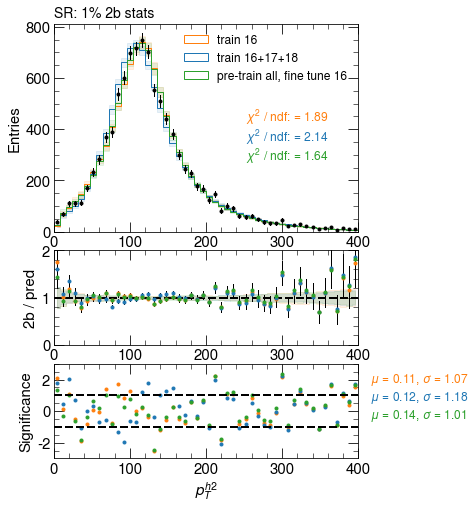

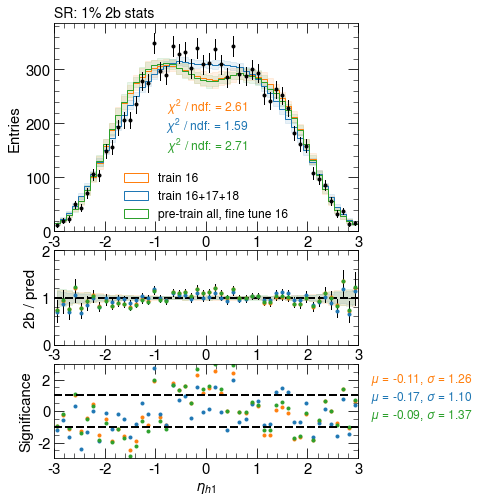

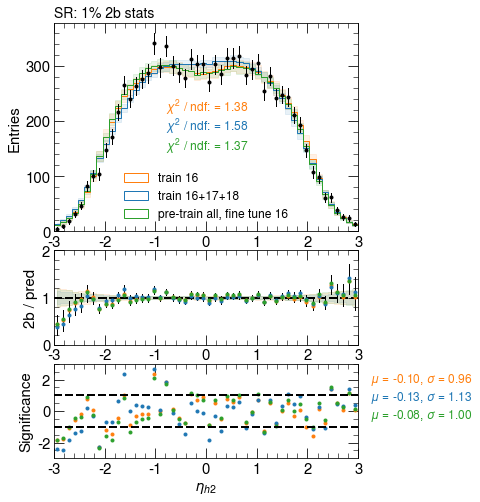

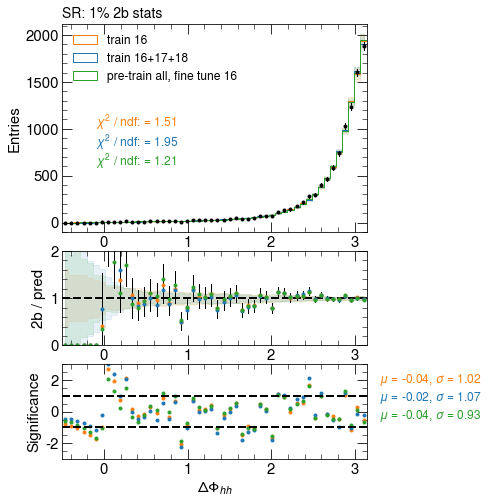

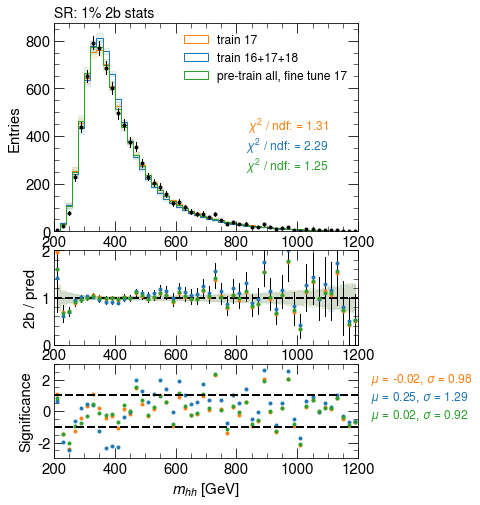

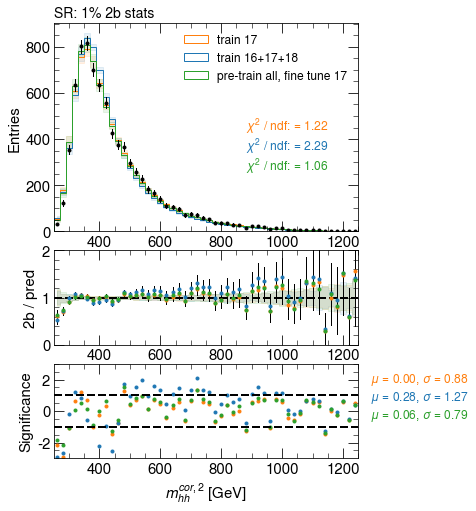

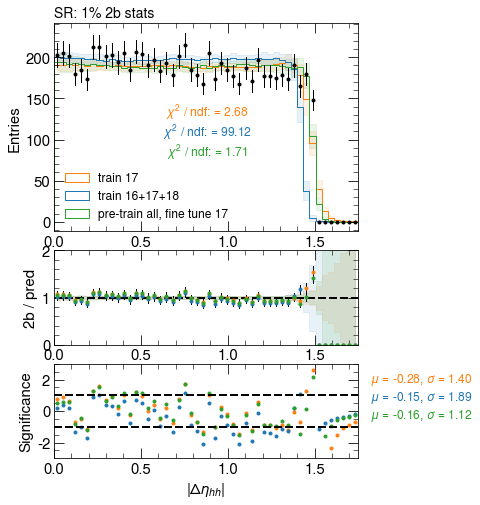

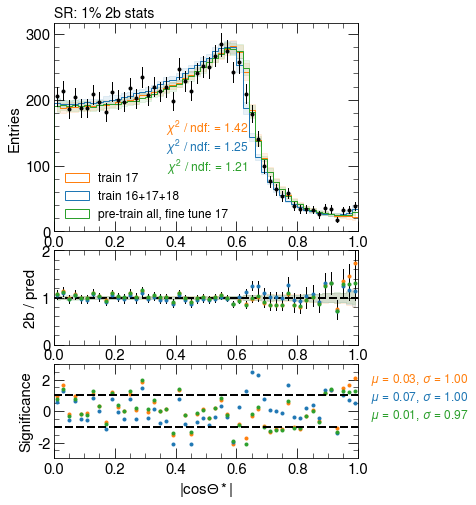

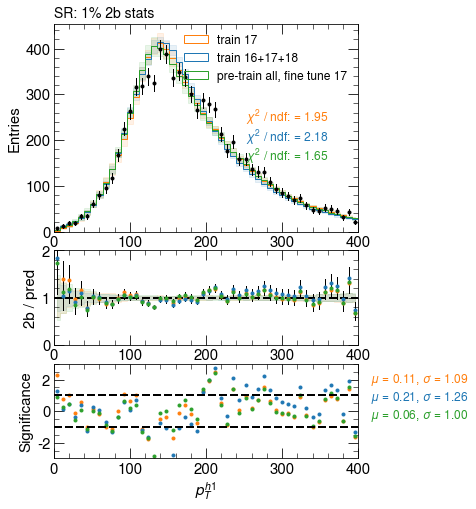

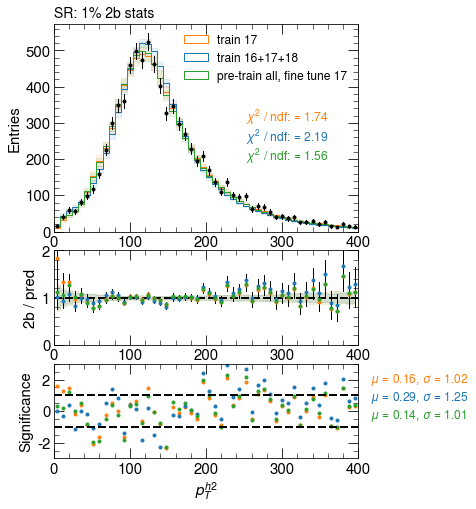

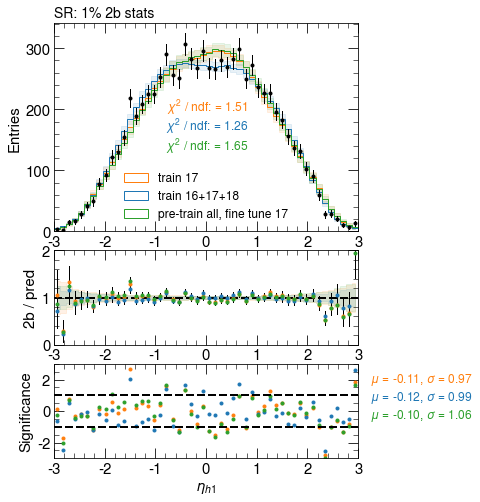

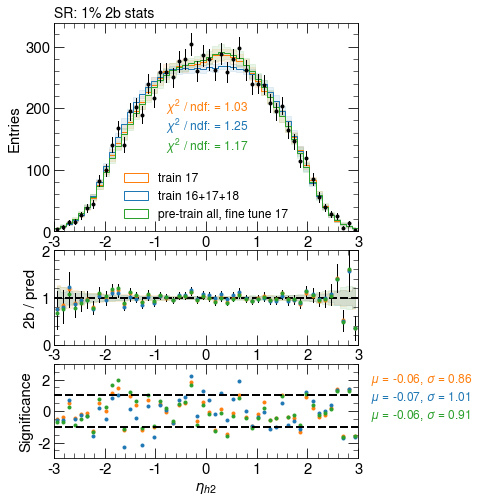

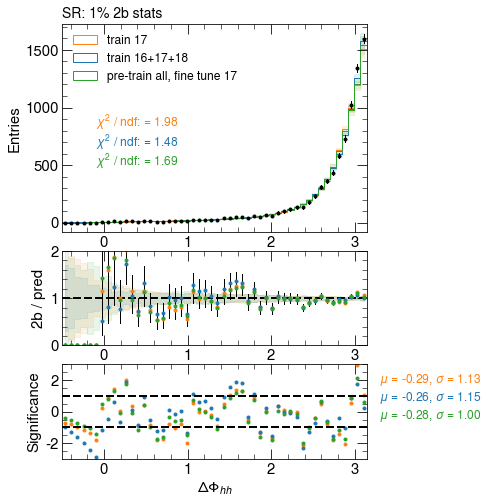

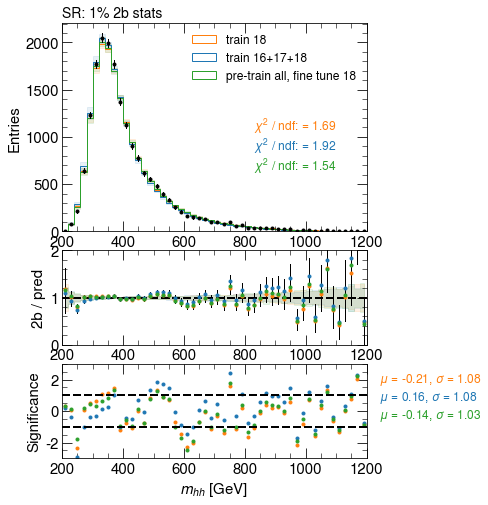

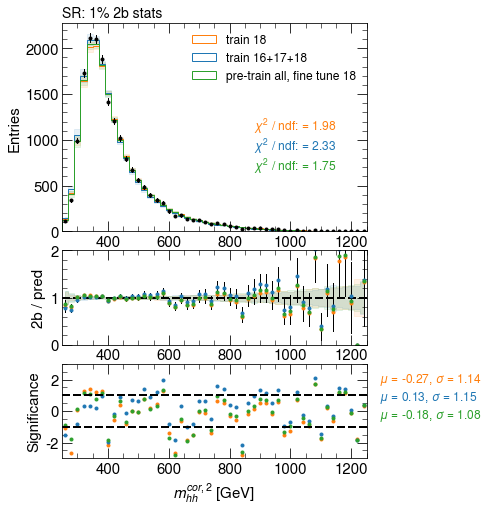

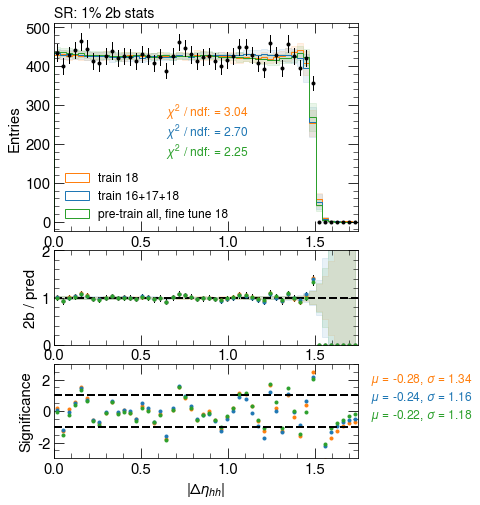

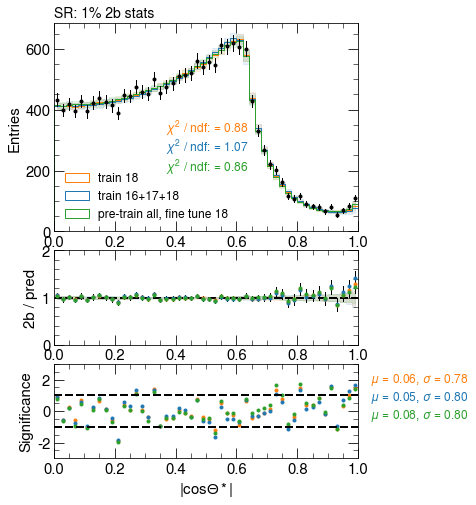

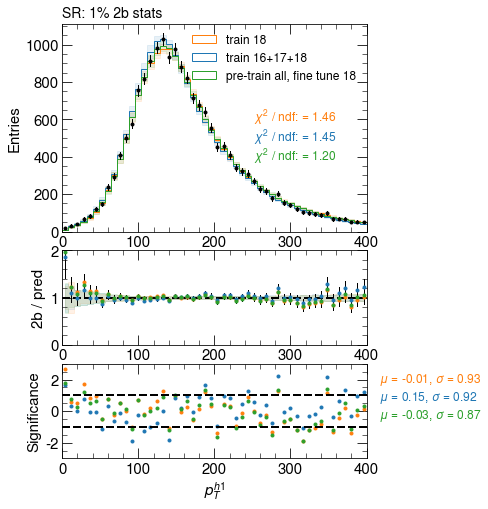

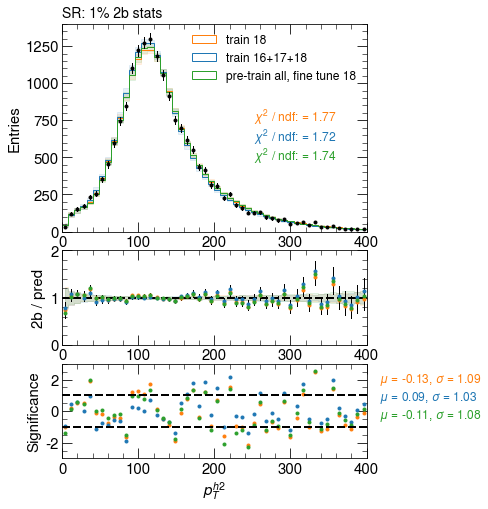

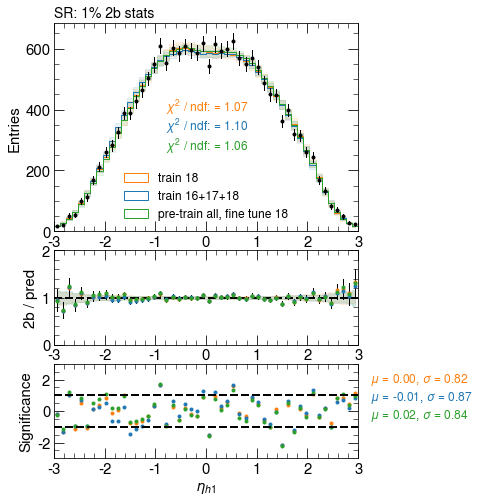

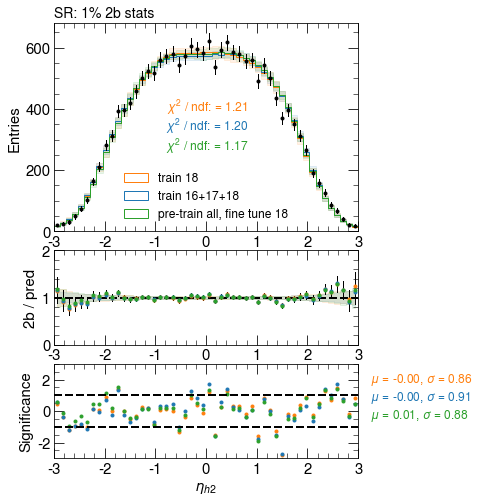

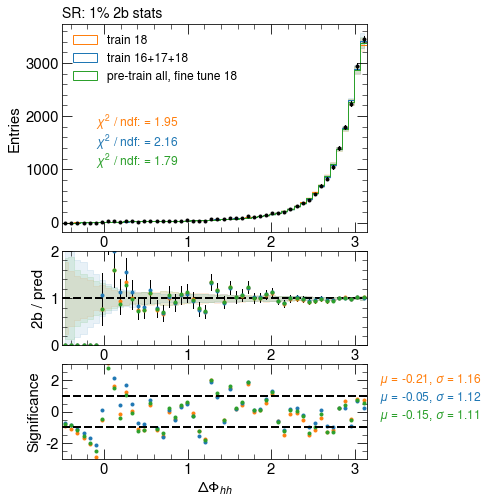

In [39]:
for yr in [16,17,18]:

    subDir = f'data{yr}_PFlow-FEB20-5jets'
    d = data(5, yr, prodTag, tag, ntag, s)

    mask = (d.df.abs_deta_hh < 1.5)  
    d.mlPrepare(mask,cols,N=-1)
    
    df = d.df[mask & (d.df.kinematic_region==0)]
    
    for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                                  [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                                  [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                                  ['right','right','center','center','right','right','center','center','left'],
                                  ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

        # Make the figure
        fig = plt.figure(figsize=(12,8))
        gs = gridspec.GridSpec(4,2)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
        ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

        #n_2b,e = np.histogram(d18.df.loc[mask,c],bins,r)
        n_2b,e = np.histogram(df[c],bins,r)
        xx = 0.5 * ( e[1:] + e[:-1] )
        
        h_2b[yr][c] = n_2b
        
        # Add text for the chi^2s for these comparisons
        ls,lc = [], []
        zs,zc = [], []

        for i,color,l in zip([0,1,2],['C1','C0','C2'] ,
                             [f'train {yr}','train 16+17+18',f'pre-train all, fine tune {yr}']):

            nom,std = hists[yr][i][f'{c}_mean'],hists[yr][i][f'{c}_std']

            ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
            ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

            ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
            ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

            X2 = chisquare(n_2b,nom)[0]
            ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
            lc.append(color)

            z = significance(n_2b,nom,std)
            ax3.plot(xx,z,lw=0,marker='.',color=color)

            mu,sigma = np.mean(z),np.std(z)
            zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
            zc.append(color)


        # Add some curves and lines which only needs to be done once
        ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
        ax2.plot(r,[1]*2,'k--',lw=2)

        ax3.plot(r,[1]*2,'k--',lw=2)
        ax3.plot(r,[-1]*2,'k--',lw=2)

        # legends
        ax1.set_ylabel('Entries')
        ax2.set_ylabel('2b / pred')
        ax3.set_ylabel('Significance')
        ax3.set_xlabel(xl)

        # ranges
        ax1.set_xlim(r)
        ax2.set_ylim(0,2)
        ax3.set_ylim(-3, 3)
        ax1.legend(fontsize=12)

        ax1.set_title(title,loc='left',fontsize=14)

        x = wx*r[1]+ (1-wx)*r[0]
        y = wy*ax1.get_ylim()[1]
        rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
        rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

        #plt.savefig(f'{figDir18}/{c}_SR.pdf',bbox_inches='tight')
        #break

**Next: Combine all the years together**

In [51]:
h_ind = {}
h_all = {}
h_pre = {}

h_2b['all'] = {}

for c in myVars:
    
    # mean
    h_ind[f'{c}_mean'] = np.sum(np.column_stack([hists[yr][0][f'{c}_mean'] for yr in yrs]),axis=1)
    h_all[f'{c}_mean'] = np.sum(np.column_stack([hists[yr][1][f'{c}_mean'] for yr in yrs]),axis=1)
    h_pre[f'{c}_mean'] = np.sum(np.column_stack([hists[yr][2][f'{c}_mean'] for yr in yrs]),axis=1)
    
    # std - sum in quadrature
    h_ind[f'{c}_std'] = np.sqrt(np.sum(np.column_stack([hists[yr][0][f'{c}_std']**2 for yr in yrs]),axis=1))
    h_all[f'{c}_std'] = np.sqrt(np.sum(np.column_stack([hists[yr][1][f'{c}_std']**2 for yr in yrs]),axis=1))
    h_pre[f'{c}_std'] = np.sqrt(np.sum(np.column_stack([hists[yr][2][f'{c}_std']**2 for yr in yrs]),axis=1))
    
    # 2b
    h_2b['all'][c] = np.sum(np.column_stack([h_2b[yr][c] for yr in yrs]),axis=1)
       

In [54]:
betaStr = r'$\beta$'

title = f'NSF: L={L:.0f}, H={H:.0f}, {nb:.0f} block, lr={lr:.0e}, {betaStr}={beta:.0e}, p={p}'
title

'NSF: L=10, H=32, 1 block, lr=1e-03, $\\beta$=1e-06, p=0.1'

In [56]:
figDir = 'figures/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/trainAll'

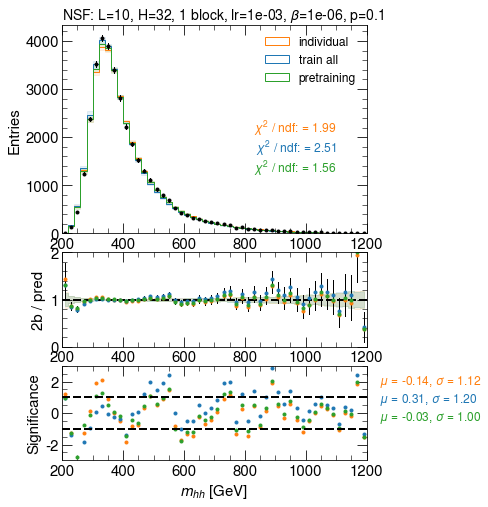

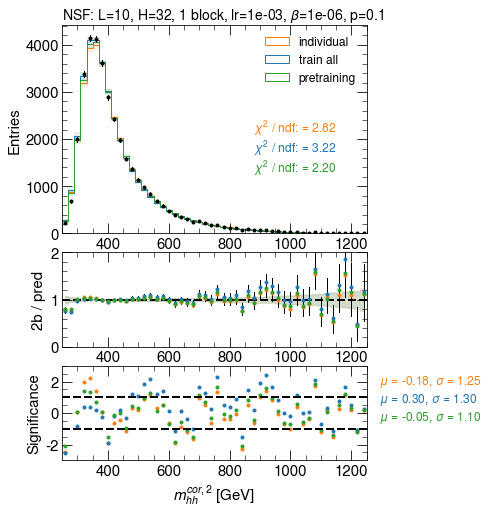

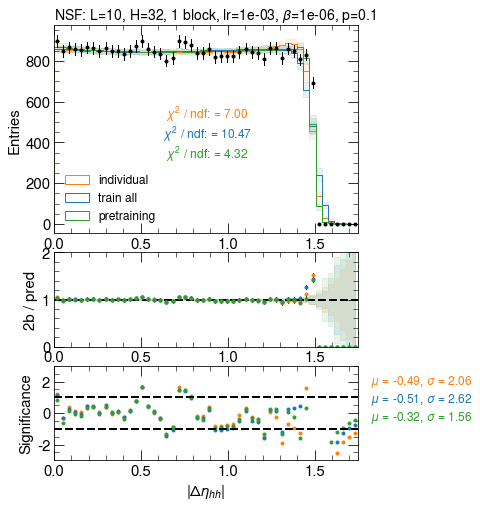

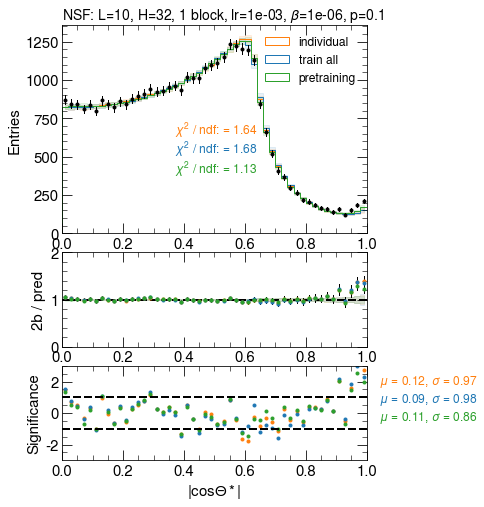

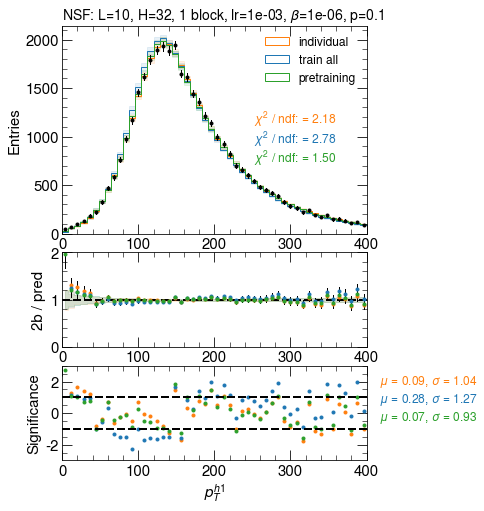

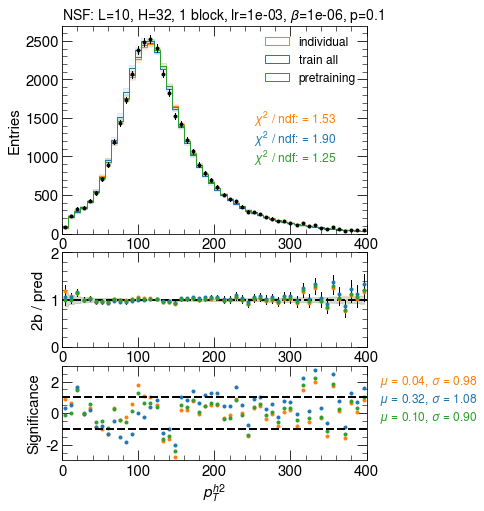

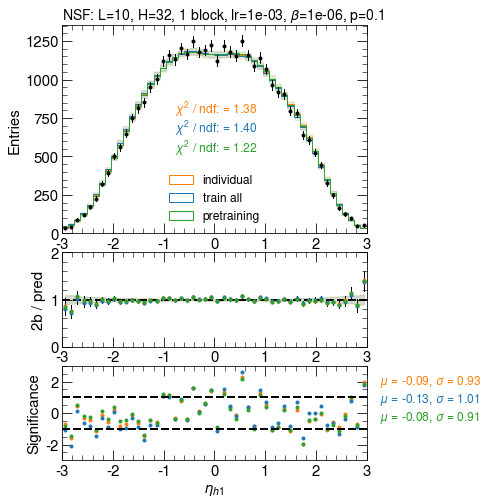

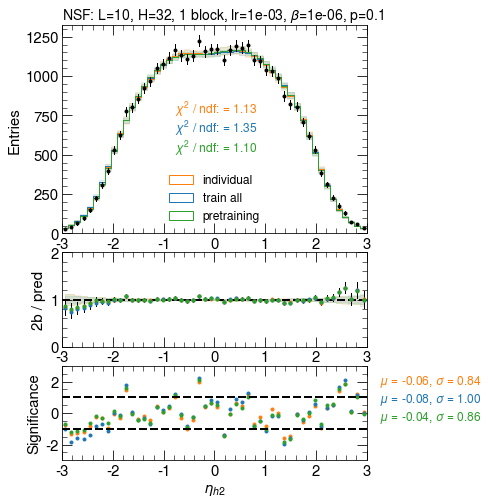

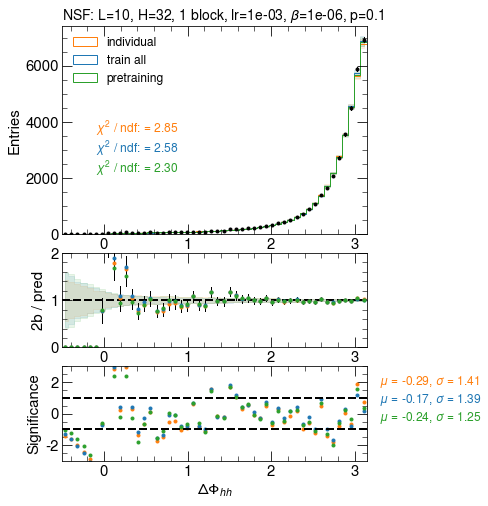

In [58]:
for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

    _,e = np.histogram(0,bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )

    n_2b = h_2b['all'][c]

    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []

    for h,color,l in zip([h_ind,h_all,h_pre],['C1','C0','C2'] ,
                         [f'individual','train all','pretraining']):

        nom,std = h[f'{c}_mean'],h[f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)

        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)

        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)


    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)

    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)

    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)

    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)

    ax1.set_title(title,loc='left',fontsize=14)

    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

    plt.savefig(f'{figDir}/{c}_SR.pdf',bbox_inches='tight')
    #break

Ok - I think it's *awesome* that I did this study, but I'm not even seeing better overall agreement when training everything together instead of training the years separately.

## Next: compare with the flow prediction when we put the GP in the mix as well

In [62]:
hdict = {} # GP + flow
fdict = {} # flow only

fc = f'../gp-for-flows/configs/val1.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

subDir = f'data161718_PFlow-FEB20-5jets'
modelDir = f'../gp-for-flows/models/{subDir}{tag}_2b_detaCut'
modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

with open(f'{modelDir}/{modelConfig}/hists_gp_100k.json','r') as hfile:
    out = json.load(hfile)

with open(f'{modelDir}/{modelConfig}/hists_flow_10preds.json','r') as hfile:
    fout = json.load(hfile)

for k in out.keys():
    hdict[k] = np.array( out[k])
    fdict[k] = np.array(fout[k])

print(modelConfig)

nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0


In [64]:
hdict.keys()

dict_keys(['m_hh_SR_mean', 'm_hh_SR_std', 'm_hh_VR_mean', 'm_hh_VR_std', 'm_hh_CR_mean', 'm_hh_CR_std', 'm_hh_cor2_SR_mean', 'm_hh_cor2_SR_std', 'm_hh_cor2_VR_mean', 'm_hh_cor2_VR_std', 'm_hh_cor2_CR_mean', 'm_hh_cor2_CR_std', 'abs_deta_hh_SR_mean', 'abs_deta_hh_SR_std', 'abs_deta_hh_VR_mean', 'abs_deta_hh_VR_std', 'abs_deta_hh_CR_mean', 'abs_deta_hh_CR_std', 'absCosThetaStar_SR_mean', 'absCosThetaStar_SR_std', 'absCosThetaStar_VR_mean', 'absCosThetaStar_VR_std', 'absCosThetaStar_CR_mean', 'absCosThetaStar_CR_std', 'pT_h1_SR_mean', 'pT_h1_SR_std', 'pT_h1_VR_mean', 'pT_h1_VR_std', 'pT_h1_CR_mean', 'pT_h1_CR_std', 'pT_h2_SR_mean', 'pT_h2_SR_std', 'pT_h2_VR_mean', 'pT_h2_VR_std', 'pT_h2_CR_mean', 'pT_h2_CR_std', 'eta_h1_SR_mean', 'eta_h1_SR_std', 'eta_h1_VR_mean', 'eta_h1_VR_std', 'eta_h1_CR_mean', 'eta_h1_CR_std', 'eta_h2_SR_mean', 'eta_h2_SR_std', 'eta_h2_VR_mean', 'eta_h2_VR_std', 'eta_h2_CR_mean', 'eta_h2_CR_std', 'dphi_hh_SR_mean', 'dphi_hh_SR_std', 'dphi_hh_VR_mean', 'dphi_hh_VR_std

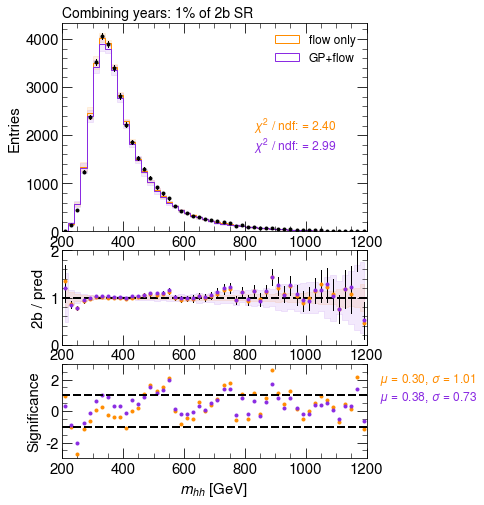

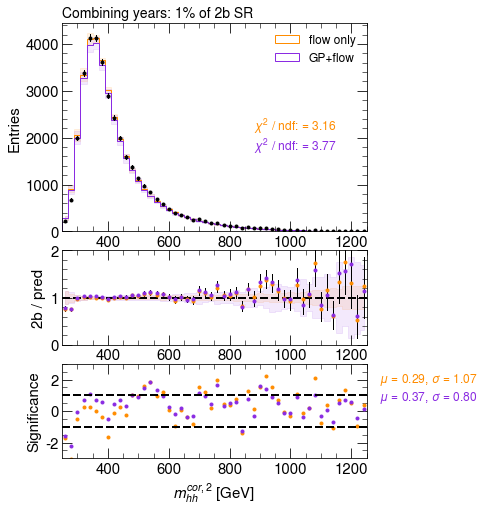

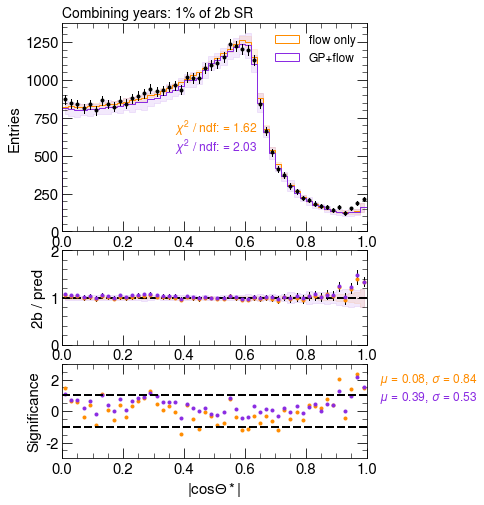

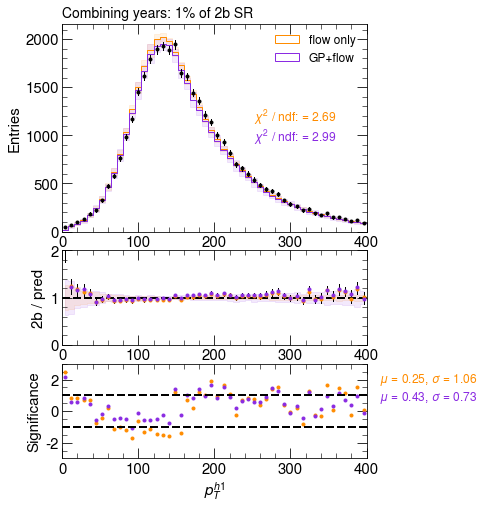

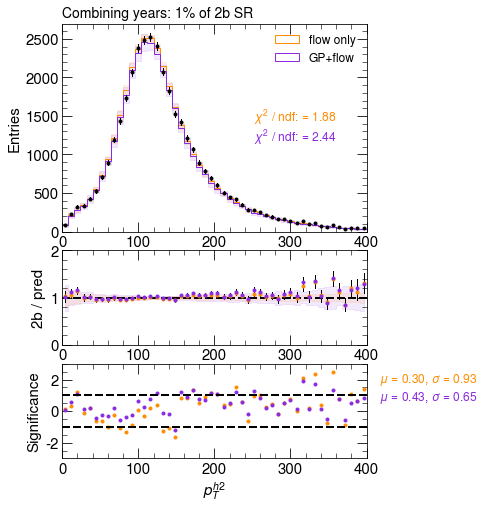

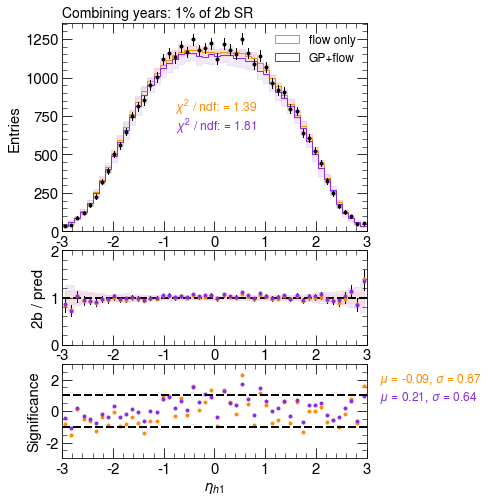

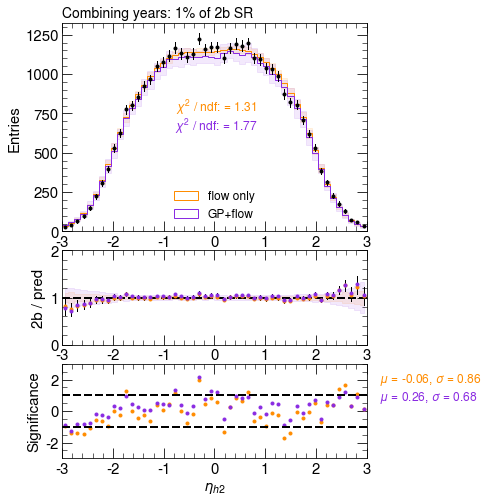

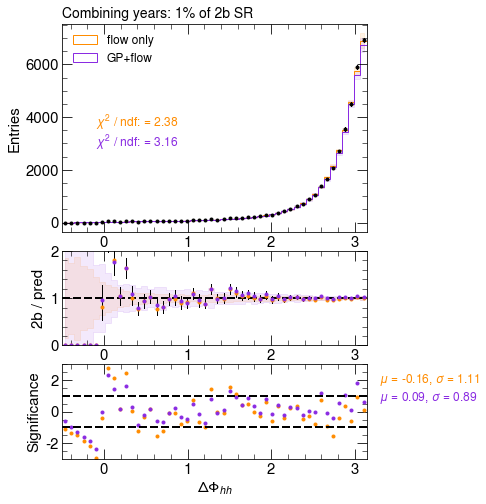

In [75]:
for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    
    if c == 'abs_deta_hh': continue
    
    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

    _,e = np.histogram(0,bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )

    n_2b = h_2b['all'][c]
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []

    for h,color,l in zip([fdict,hdict],['darkorange','blueviolet'], ['flow only','GP+flow']):

        nom,std = h[f'{c}_SR_mean'],h[f'{c}_SR_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)

        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)

        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)


    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)

    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)

    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)

    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)

    ax1.set_title('Combining years: 1% of 2b SR',loc='left',fontsize=14)

    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

    plt.savefig(f'{figDir}/{c}_SR.pdf',bbox_inches='tight')
    #break

Hmmmmm - why are the $\chi^2$s for the flow slightly different than when I was comparing in the plots above?

In [72]:
h_all['m_hh_mean']

array([  12.904,  165.484,  576.484, 1356.024, 2467.352, 3510.364,
       4011.516, 3897.868, 3414.192, 2837.548, 2298.376, 1865.748,
       1519.256, 1247.128, 1036.156,  865.404,  729.536,  614.768,
        524.316,  452.24 ,  387.684,  335.508,  292.024,  253.48 ,
        221.74 ,  193.344,  167.732,  147.032,  129.28 ,  112.008,
         97.212,   84.824,   74.012,   64.064,   55.344,   47.972,
         41.116,   35.496,   30.24 ,   25.252,   21.38 ,   18.256,
         15.616,   13.872,   10.936,    9.292,    7.748,    6.372,
          5.152,    4.648])

In [73]:
fdict['m_hh_SR_mean']

array([  12.52 ,  164.156,  574.204, 1347.36 , 2459.84 , 3508.092,
       4021.18 , 3915.132, 3426.232, 2840.804, 2292.908, 1861.156,
       1512.704, 1244.988, 1035.168,  861.672,  727.212,  617.348,
        524.716,  450.652,  387.424,  336.872,  290.288,  254.552,
        219.964,  191.952,  168.98 ,  147.524,  129.456,  112.512,
         98.332,   86.236,   73.868,   64.748,   55.7  ,   48.176,
         41.644,   35.988,   30.98 ,   25.772,   21.98 ,   18.488,
         15.52 ,   13.124,   11.096,    9.224,    7.636,    6.556,
          5.432,    4.372])

I don't know why $\chi^2$s are better, but since there's stochasticity in the sampler, I think the fact that there's some discrepancy in the sampler could account for this difference.

## 2016 GP fit with p=0.1 2b downsampling

Lastly - this study isn't really in keeping w/ the eval all years together theme - but it is related to an excess I was seeing in the (downsampled) 2016 dataset, so I'm going to try looking at the p=10% massplane fit, but evaluating w/ one of the downsampled flows.

In [93]:
h16 = {} # GP + flow
f16 = {} # flow only

modelDir = f'../gp-for-flows/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut'

with open(f'{modelDir}/{modelConfig}/hists_gp_100k_eval_p_0.1.json','r') as hfile:
    out = json.load(hfile)

with open(f'{modelDir}/{modelConfig}/hists_flow_1preds_eval_p_0.1.json','r') as hfile:
    fout = json.load(hfile)

for k in out.keys():
    h16[k] = np.array( out[k])
    f16[k] = np.array(fout[k])

print(modelConfig)

nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0


In [87]:
?data

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.1_2b.h5


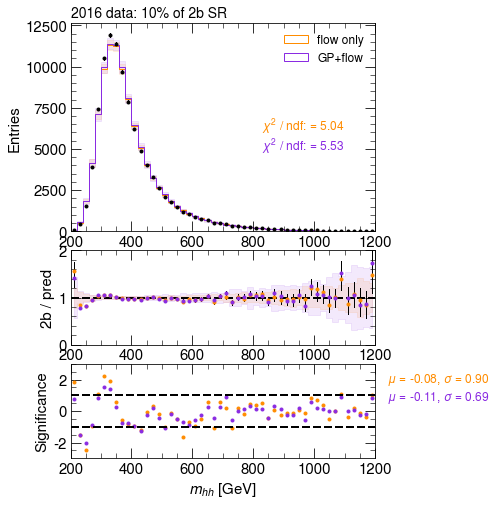

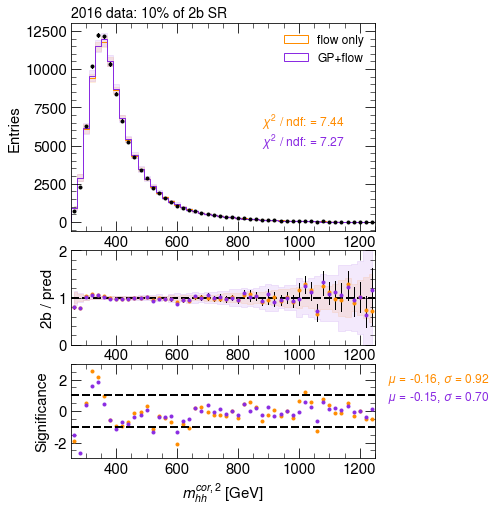

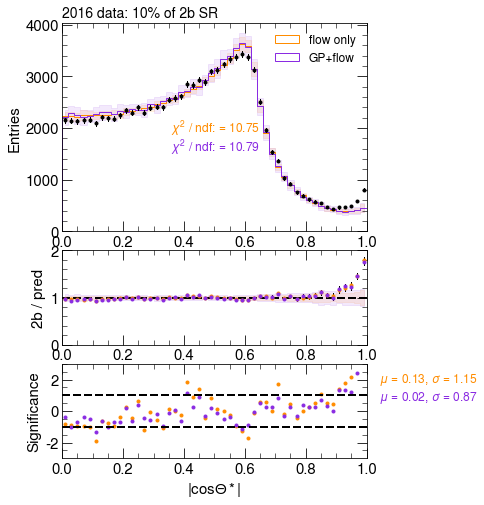

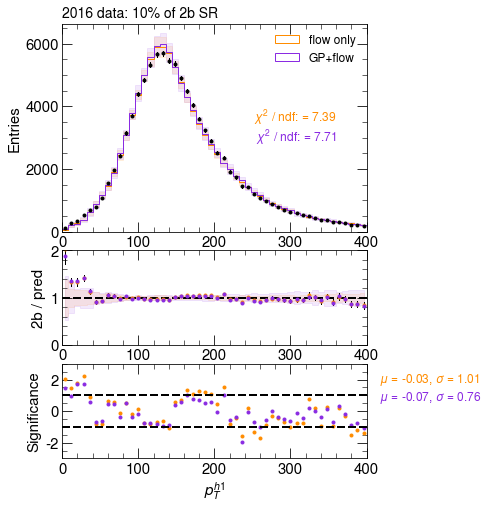

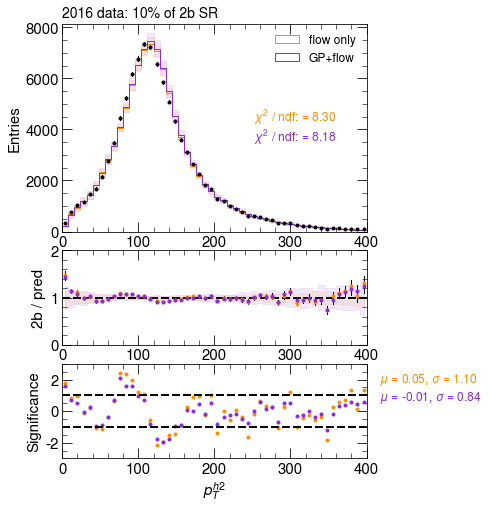

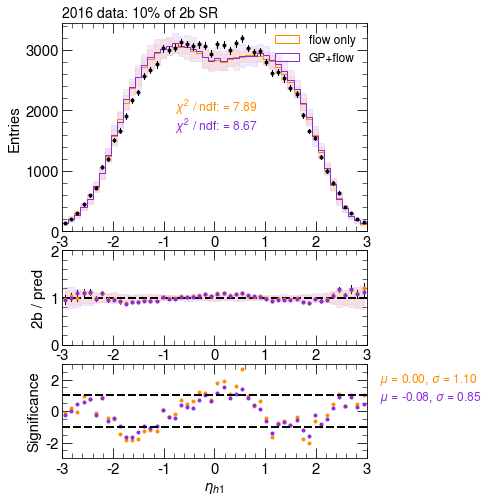

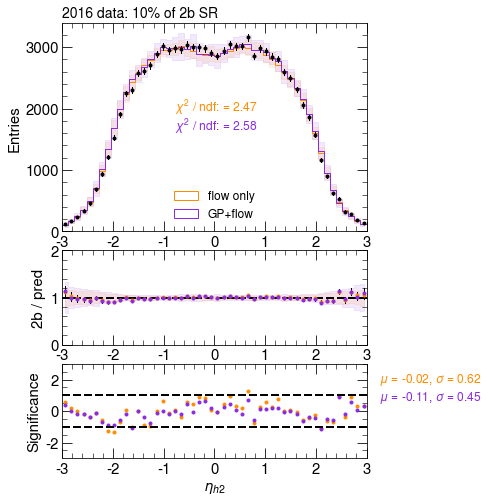

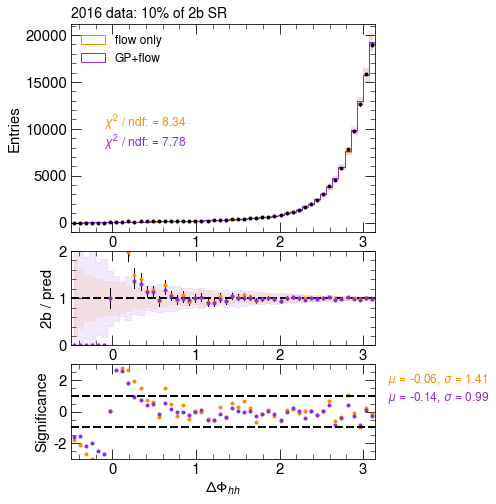

In [94]:
subDir_16 = 'data16_PFlow-FEB20-5jets'
tag_0p1 = '_SM_2b_p_0.1'
d = data(5, yr, prodTag, tag_0p1, ntag, s)

df = d.df[(d.df.abs_deta_hh < 1.5)  & (d.df.kinematic_region==0)]

for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    
    if c == 'abs_deta_hh': continue
    
    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

    n_2b,e = np.histogram(df[c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )

    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []

    for h,color,l in zip([f16,h16],['darkorange','blueviolet'], ['flow only','GP+flow']):


        nom,std = h[f'{c}_SR_mean'],h[f'{c}_SR_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)

        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)

        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)

    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)

    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)

    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)

    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)

    ax1.set_title('2016 data: 10% of 2b SR',loc='left',fontsize=14)

    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

    plt.savefig(f'figures/{subDir_16}{tag_0p1}_{ntag}b_detaCut/{modelConfig}/train_p_0.01/{c}_SR.pdf',bbox_inches='tight')
    break